# Fashion MNIST benchmark

In this notebook, we take a closer look on different neural networks (NNs). We will use the same classification problem as
[the previous entry](../1.Pytorch_tutorial/Simple_Pytorch.ipynb)
with the same data. Now, instead of a fully connected network (FCN), we will persue new avenues by which a NN can analyse image data and to use locality as information of the input, i.e., close pixels may share local information about the image. We will introduce new type of layers capable of doing the task: convolusional and pooling layers.
We will explain in further detail what those layers do and how we may implement them in a convolutional NN (CNN).

We will also use regularization methods and compare the results.

## 1. Prerequesites

As always, loading libraries and data is the first priority.

In [1]:
# Show if the system has installed an Nvidia graphics card
! lspci | grep "3D controller"

01:00.0 3D controller: NVIDIA Corporation GP107M [GeForce GTX 1050 Mobile] (rev a1)


In [2]:
import torch

# Is PyTorch capable of use NVidia card?
if torch.cuda.is_available():
    print("Yes, you have CUDA available.")
else:
    print("Only CPU is available.")

Yes, you have CUDA available.


Now, load dataset libraries. This time [`timeit` library](https://docs.python.org/3/library/timeit.html) is called to measure iterations and approximate training time, since we are going to be training multiple models. We will also use [`pathlib.Path`](https://docs.python.org/3/library/pathlib.html#pathlib.Path) to save and load the models.

In [6]:
from IPython.display import clear_output # for-loop status print
import timeit # for-loop status print
from pathlib import Path # Save filesystem locations

import torch
from torch import nn
from torch.utils.data import DataLoader # Iterable of samples
from torchvision import datasets # Object to access dataset
from torchvision.transforms import ToTensor # PIL image to Tensor object

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Set path for models we will later train and save.

In [21]:
models_d = Path('models')

Since Fashion MNIST dataset is used, we will continue to list useful resources here:
 * [FashionMNIST class](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#fashionmnist)
 * [VisionTorch library index](https://pytorch.org/vision/stable/genindex.html)
 * [VisionDataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.VisionDataset.html#visiondataset), the base class for MNIST which in turn is the base class for FashionMNIST.

Also relevant for this code:
 * [ToTensor()](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#totensor) method on the images.
 * [PIL library](https://pypi.org/project/pillow/) was the Python Image Library. Now it's no longer maintained, however there's a fork called Pillow. This type of [objects](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image) are the ones to load images into the TorchVision env.

In [23]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data", # It's where the dataset is going to be saved (e.g. in "./data/" dir)
    train=True, # Create dataset from train-images-idx3-ubyte
    download=True, # Download dataset from the internet (only if it doesn't exits already locally
    transform=ToTensor(), # Transformation on a PIL image into a 3d matrix scaled (Color x Height x Width) (that's what ToTensor() does)
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # Create dataset from t10k-images-idx3-ubyte
    download=True,
    transform=ToTensor(),
)

Next step is to use a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to wrap up the datasets.

In [24]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


For now, we will display a small sample of images from the test dataset.

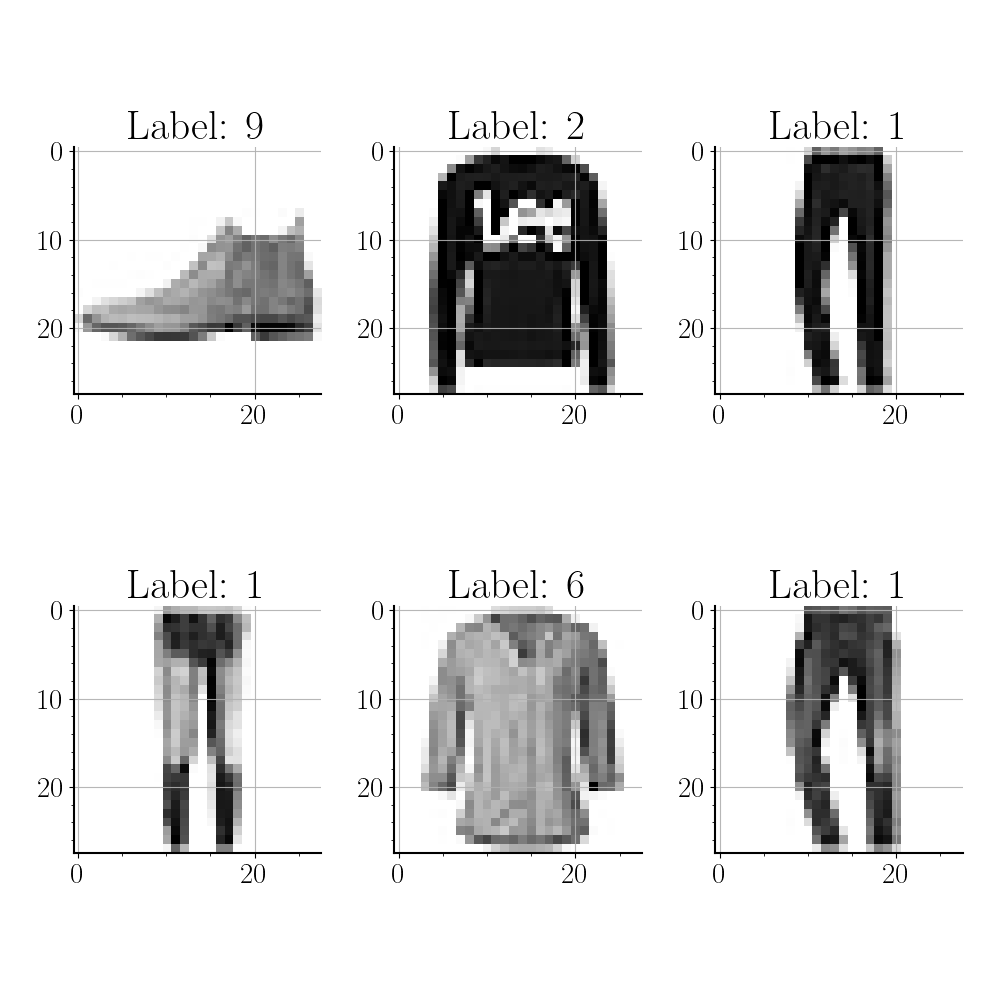

In [25]:
import matplotlib.pyplot as plt
%matplotlib widget

Nrows, Ncols = 2,3

fig, ax = plt.subplots(Nrows, Ncols, figsize=(10,10))
ax = ax.reshape(-1)

ims, lbls = None, None
for X, y in test_dataloader:
        

    ims = X[:ax.shape[0],0]
    lbls = y[:ax.shape[0]]
    break

for i, (im, lbl) in enumerate(zip(ims, lbls)):
    ax[i].imshow(im, 'Greys')
    ax[i].set_title("Label: " + str(lbl.item()))



# Models

Here we will define multiple different models, including the one [used in the Pytorch tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html). We then compare each one.

We will design 4 different models. First, a FCN as our baseline from our preivous notebook.
Next we will use Le Net model, designed by Y. Lecun et al. ([10.1109/5.726791](https://doi.org/10.1109/5.726791)) in 1998.
This model uses convolution layers, these layers are used to extract features by convoluting a kernel (e.g. 2x2 matrix) through out the pixel values of the image. This will signal where in the image one can find a feature defined by the kernel. We will use multiple different kernels and we may train kernel values as any other model parameter.
Usually this layer is implemented multiple times in a single model, after which we use an activation layer to make it non-linear.
After an activated convoluted input, we may try to reduce input space by using a pooling layer, which summarizes a subsample of the input into a single value. In the case of Le Net, we use average pooling layers, which finds the average value of the pixels found inside the subsample (e.g. a square of 3x3).
After enough feature and sample reduction is made, we connect the last hidden layer into a perceptron (a FCN with only one hidden layer) to make a prediction.

The next two will be a modern CNN using max pooling and ReLU, however, only one of them will adapt Dropout layers, to avoid the model on fixation in a small subset of pixels. Max pooling has become the defacto pooling method, since extracting the maximum pixel value ensures the feature with the most importance is sent to the next layer. Average pooling is limited by low values on the input since it contributes to lower values into the next layer. Also, the sigmoid has been changed to ReLU since the latter lacks the vanishin gradient problem. Both changes will ensure the last two models learn much faster, and extract and use much more valuable features from the input.

The reasoning behind he last model is to introduce regularization algorithms to the training section in order to generalize the model and avoid over focusing on the training data (a.k.a. overfitting). We will introduce dropout layers into the model, as well as l2 regularization on the loss function, that is, add a positive term to the loss cost proportional to the magnitude of the parameters:

$$
L'(y,\hat y) = L(y, \hat y) + \alpha  \|{\textbf w}\|^2
$$
where $L'(y, \hat y)$ is the new loss function to apply the learning algorithm on, $L(y, \hat y)$ the original loss function, in this example will be the cross-entropy, $\alpha$ will be the factor by which the l2 term is multiplied and $\|{\textbf w}\|^2$ is the squared euclidean distance of the parameter space for the model $\textbf w$. This will help the model to avoid using extreme parameter values, at the same time avoiding focusing only on a small subset of parameters and instead use broader information to perform training.

Learning algorithms which implement gradients must also compute l2-term gradient.


A note on pooling and convolution layers: when dealing near edges, one might *extend* the range of the convolution to ensure the same size for output and input. In these cases, we may fill the padded edges with 0s, but we can also set the value to the mean of nearby input, Pytorch set the values to 0 by default. Also, we may want to move the kernel 

Useful documentation:

 * [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#module), a base class for neural network modules.
 * [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten), flattens a multiple dim tensor into a single dim tensor (vector).
 * [nn.Linear](https://pytorch.org/docs/stable/notes/mps.html#mps-backend) for a linear transformation.
 * [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#relu), Rectified Linear Unit fuction.
 * [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#sequential), combine multiple functions in a cascading way.
 * [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#flatten), flat the 1x28x28 image into a single 1D vector.

The new elements:
 * [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d), 2D convolusion of multiple kernel, each generating an input plane.
 * [nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid), the sigmoid function as an activation layer.
 * [nn.AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html#torch.nn.AvgPool2d), 2D average pooling from multiple input planes.
 * [nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#dropout), during training, randomly set inputs to 0.

When desinging NNs, it's important to keep input and output dimensions of each layer consistent with the preceding and subsequent layers.

In [26]:
# Define model
class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [27]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_cnn = nn.Sequential(
            # Input 1x28x28 Output 6x28x28
            nn.Conv2d(
                in_channels = 1,
                out_channels = 6,
                kernel_size = (5,5),
                stride = 1,
                padding = 2,
            ),
            nn.Sigmoid(),

            # Input 6x28x28 Output 6x14x14
            nn.AvgPool2d(
                kernel_size = (2,2),
                stride=2,
                padding=0,
                ceil_mode=False,
                count_include_pad=True,
                divisor_override=None
            ),

            # Input 6x14x14 Output 16x10x10
            nn.Conv2d(
                in_channels = 6,
                out_channels = 16,
                kernel_size = (5,5),
                stride = 1,
                padding = 0,
            ),
            nn.Sigmoid(),

            # Input 16x10x10 Output 16x5x5
            nn.AvgPool2d(
                kernel_size = (2,2),
                stride=2,
                padding=0,
                ceil_mode=False,
                count_include_pad=True,
                divisor_override=None
            )
        )

        self.flatten = nn.Flatten(
            start_dim = 1,
            end_dim = -1
        )

        self.linear_fcn = nn.Sequential(
            # Input 400 Output 120
            nn.Linear(
                in_features = 400,
                out_features = 120,
                bias=True
            ),
            nn.Sigmoid(),

            # Input 120 Output 84
            nn.Linear(
                in_features = 120,
                out_features = 84,
                bias=True
            ),
            nn.Sigmoid(),

            # Input 84 Output 10
            nn.Linear(
                in_features = 84,
                out_features = 10,
                bias=True
            )
        )

    def forward(self, x):
        x = self.linear_cnn(x)
        x = self.flatten(x)
        x = self.linear_fcn(x)
        return x

For the CNNs, we only need to define it once and use the dropout probability as input for the model initialization. One model will not have dropout ($p=0$) and the other will ($p=0.3$)

In [29]:
class CNN(nn.Module):
    def __init__(self, dropout_rate = 0.0):
        super().__init__()
        self.linear_cnn = nn.Sequential(
            # Input 1x28x28 Output 16x28x28
            nn.Conv2d(
                in_channels  = 1,
                out_channels = 16,
                kernel_size  = (3,3),
                stride       = 1,
                padding      = 1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # Input 16x28x28 Output 16x28x28
            nn.Conv2d(
                in_channels  = 16,
                out_channels = 16,
                kernel_size  = (3,3),
                stride       = 1,
                padding      = 1),
            nn.ReLU(),

            # Input 16x28x28 Output 16x14x14
            nn.MaxPool2d(
                kernel_size = 2,
                stride = None)
        )

        self.flatten = nn.Flatten()

        # Input (flatten) 16x28x28 Output 1x10
        self.linear_fcn = nn.Sequential(
            nn.Linear(3136, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(84, 10)
        )
        

    def forward(self, x):
        x = self.linear_cnn(x)
        x = self.linear_fcn(self.flatten(x))
        return x

## Training and testing methods

We implement the same methods for training and testing with a slight difference on the prints and testing outputs.

In [30]:
def train(dataloader, model, loss_fn, optimizer, status = False):
    size = len(dataloader.dataset)
    model.train() # Set train mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad() # Reset gradient values to 0
        loss.backward()
        optimizer.step() # Learning time!

        if status:
            if (batch % 100 == 0):
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [33]:
def test(dataloader, model, loss_fn, status = False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Set evaluation mode
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    if status:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return {"test_loss" : test_loss, "correct" : correct} # output accuracy and loss function value

We define a general method for training and testing. Here, we define new regularization rules and momentum on the SGD algorithm. We implement regularization only on the last CNN model so we may compare results.

In [32]:
def epoch(model, n_epochs = 2, lr = 1e-3, momentum = 0., weight_decay = 0., status = True):

    # Send model to device's memory (CPU's RAM / graphics card)
    model = model.to(device)

    # Use Cross Entropy Loss for classification problem
    loss_fn = nn.CrossEntropyLoss()
    
    # Simples optimization algorithm (but low cost [https://doi.org/10.1109/TCYB.2019.2950779])
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = momentum, weight_decay = weight_decay)

    # Measure epoch elapsed time
    start = timeit.default_timer()
    r = [] # Save test results for each epoch

    # Training loop
    for t in range(n_epochs):
        if status:
            print(f"Epoch {t+1}\n-------------------------------")

        # Update training model a single step
        train(train_dataloader, model, loss_fn, optimizer, status = status)
        # Save testing results
        r.append(test(test_dataloader, model, loss_fn, status = status))
    
    
    
        # Print status loop
        clear_output(wait = True)
        
        stop = timeit.default_timer()
        progress = len(r)/n_epochs
        time_curr = (stop - start) / 60.
        clear_output(wait = True)

        print(f"Progress: {progress*100:>0.1f}%")
        print(f"Current runtime: {time_curr:>0.1f} min")
        print(f"Expected runtime: {time_curr / progress:>0.1f} min")
        print(f"Accuracy: {r[-1]['correct'] * 100:0.1f}%")
        print()

    return r, model

## Training

Initialize and train each model. We will iterate over 50 times each model, which is a high training period for a classification problem of Fashion MNIST.

#### Le Net

In [54]:
lenet = LeNet()
r_lenet, lenet = epoch(lenet, n_epochs = 50, lr = 1e-2, momentum = 0.9)
torch.save({
    "model" : lenet,
    "progress" : r_lenet
}, model_path + "lenet.pth")

Progress: 100.0%
Current runtime: 5.8 min
Expected runtime: 5.8 min
Accuracy: 86.5%



#### Fully Connected Network

In [55]:
fcn = FCN()
r_fcn, fcn = epoch(fcn, n_epochs = 50, lr = 1e-2, momentum = 0.9)
torch.save({
    "model" : fcn,
    "progress" : r_fcn
}, model_path + "fcn.pth")

Progress: 100.0%
Current runtime: 5.6 min
Expected runtime: 5.6 min
Accuracy: 87.8%



#### Convolutional neural network

In [57]:
cnn = CNN()
r_cnn, cnn = epoch(cnn, n_epochs = 50, lr = 1e-2, momentum = 0.9)
torch.save({
    "model" : cnn,
    "progress" : r_cnn
}, model_path + "cnn.pth")

Progress: 100.0%
Current runtime: 6.9 min
Expected runtime: 6.9 min
Accuracy: 91.4%



#### Convolutional neural network with dropout and l2 regularization

In [59]:
cnn_l2 = CNN(dropout_rate = 0.3)
r_cnn_l2, cnn_l2 = epoch(cnn_l2, n_epochs = 50, lr = 1e-2, momentum = 0.9, weight_decay = 1e-3)
torch.save({
    "model" : cnn_l2,
    "progress" : r_cnn_l2
}, model_path + "cnn_l2.pth")

Progress: 100.0%
Current runtime: 7.1 min
Expected runtime: 7.1 min
Accuracy: 90.5%



Load models and testing results, avoiding retraining of data.

In [37]:
# Load model (from file) if training was skipped
if 'r_lenet' not in globals():
    t = torch.load(models_d / "lenet.pth")
    lenet = t['model']
    r_lenet = t['progress']

if 'r_fcn' not in globals():
    t = torch.load(models_d / "fcn.pth")
    fcn = t['model']
    r_fcn = t['progress']

if 'r_cnn' not in globals():
    t = torch.load(models_d / "cnn.pth")
    cnn = t['model']
    r_cnn = t['progress']

if 'r_cnn_l2' not in globals():
    t = torch.load(models_d / "cnn_l2.pth")
    cnn_l2 = t['model']
    r_cnn_l2 = t['progress']

Display accuracy and loss cost for testing data.

Text(0.5, 1.0, 'Entropy of different models')

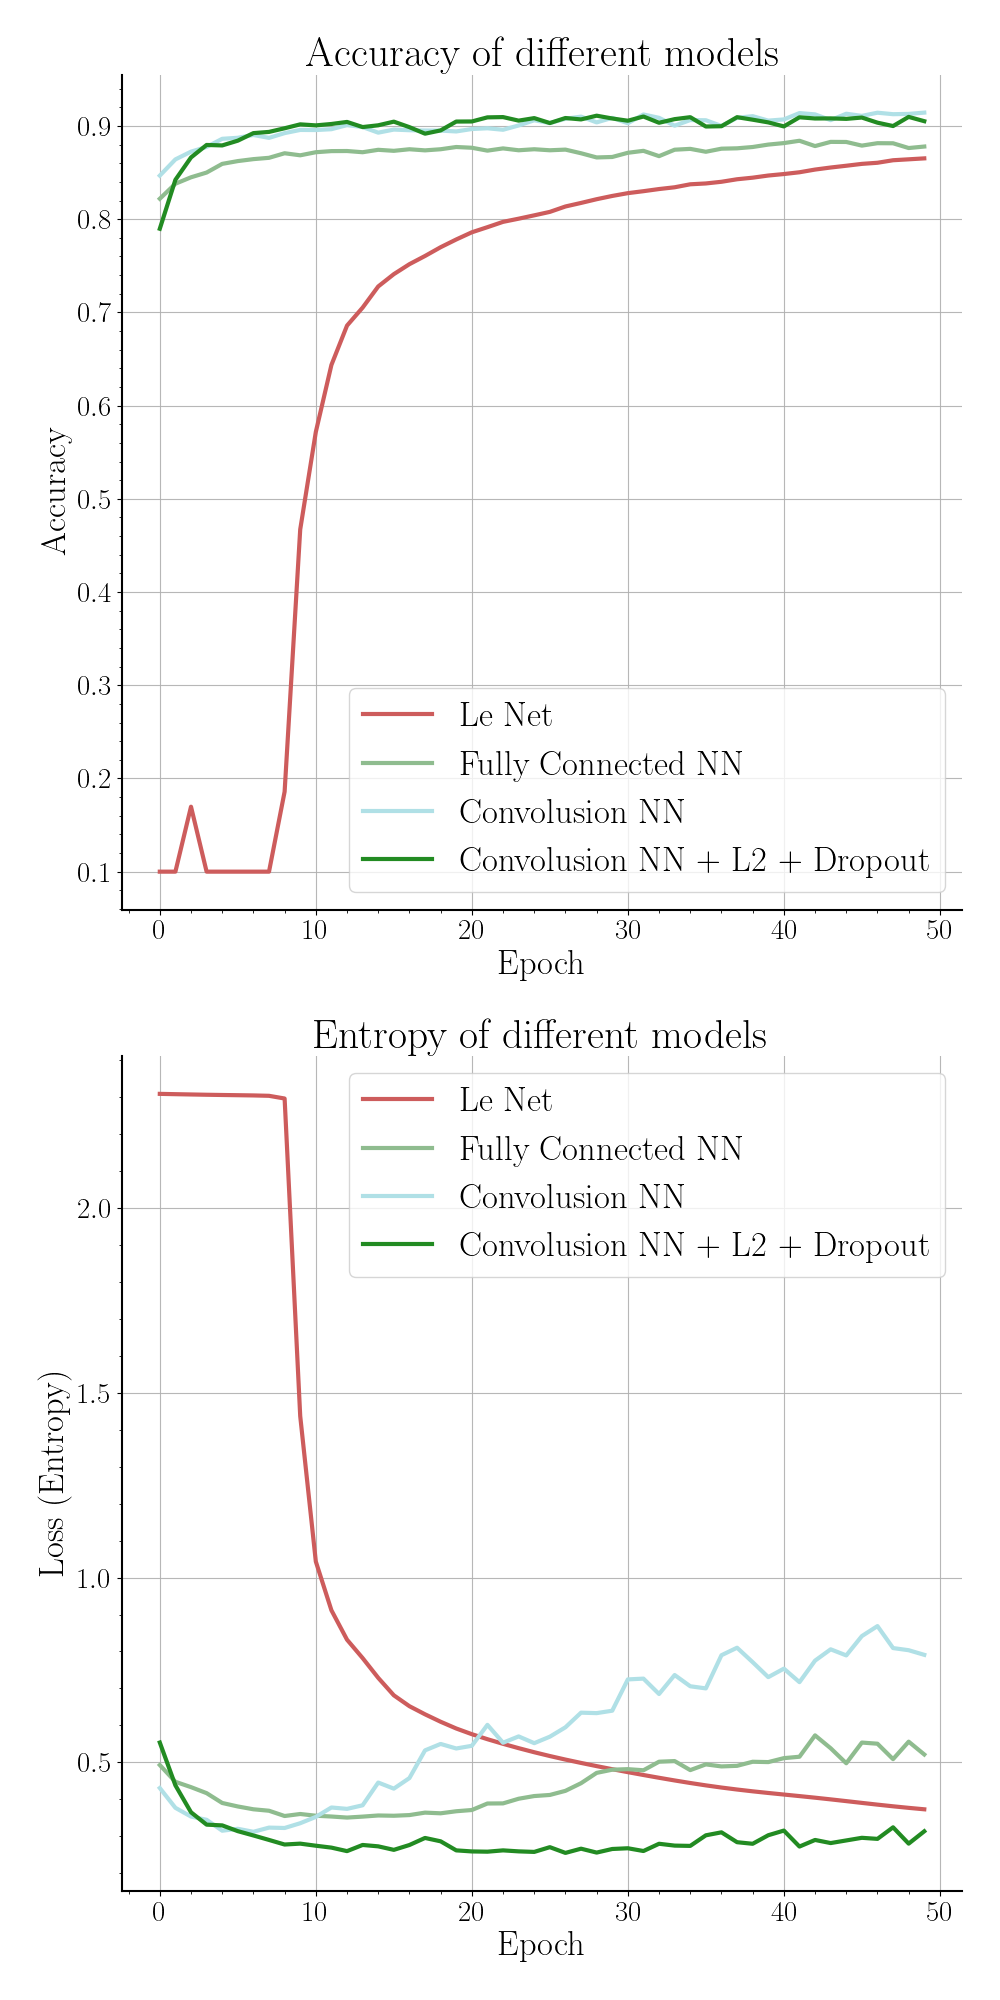

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib widget

Nrows, Ncols = 2,1

fig, axs = plt.subplots(Nrows, Ncols, figsize=(10,20))
axs = axs.reshape(-1)

rr = {"Le Net" : r_lenet,
 "Fully Connected NN" : r_fcn,
 "Convolusion NN" : r_cnn,
 "Convolusion NN + L2 + Dropout" : r_cnn_l2
}

for k, r in rr.items():
    t = pd.DataFrame(r)
    axs[0].plot(t["correct"], label = k)
    axs[1].plot(t["test_loss"], label = k)

axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title("Accuracy of different models")

axs[1].legend()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss (Entropy)')
axs[1].set_title("Entropy of different models")

### About accuracy

In the first figure we see the accuracy for the model on testing data. Each epoch/iteration is represented on the x-axis while the accuracy is represented on the y-axis. We can see each model's improvement. The CNNs and FCN accuracy rate are very similar in contrast with Le Net, which actually starts as a random prediction until the 8th iteration, where a local minimum is found on the loss function and starts learning.

This late learning curve maybe caused by a loss function depleted of structure. This also may happen by the fact that we are using average pooling and sigmoids for our activation layers, the vanishing gradient is present. The fact we are adding momentum in SGD, helps accelerate the learning process but we also find that it helps miss local minima in the 2nd iteration.

The model in question starts to stabalize at the 20th iteration, while the rest of the models reach maximum accuracy after 10 training epochs, much faster.
This demonstrates the importance of choosing the appropiate layers and algorithms in order to build a robust model.

A closer inspection on the other models show us that CNN have better results for image classification than a FCN. To note, CNN with regularization starts with a much lower success rate (~0.8) than its counterpart (~0.85) or the FCN (~0.82) but reaches the same accuracy of the former at the end.

### About entropy

The next figure shows cross entropy for testing datain each epoch and model. A lower entropy signifies the model has a better understanding for classifying an image. We expect a lowering of the entropy when training a proper model.

We clearly see it in the case of Le Net. This case is very similar but opposite to the accuracy for the same model, which is to be expected: when accuracy rises, more correct predictions are made which means the model is learning.

However, take notice of the FCN and non-regularized CNN. The entropy lowers at the beginning, but later it grows up as time goes on. This means the model is making the correct predictions, i.e., the accuracy is still high, but they are less certain of that prediction. That means that the models stop learning and actually performe worse. The models keeps learning using the same training data, which means both models are *overfitting*. They are picking up specific information of training images not found on testing data which means the models are loosing generality.

This is one of the most crucial issues of machine learning algorithms and is caused when we *overtrain* our models. To minimize the effect, for example, we may limit our models to use a subset of the pixels of the image or add a term to the cost function. We can see in this case (dark green) the model's overfitting is very slow. This is in contrast to train a CNN with no regularization parameters (light blue).

## Conclusion

We use Fashion MNIST to train 4 different NNs for image classification (see, [Learn the basics (Pytorch)](https://pytorch.org/tutorials/beginner/basics/intro.html)).
We find convolution, max pooling layers and ReLU activation functions help the model to achieve the best accuracy in relatively short amount of epochs. We also find regularization methods help the model to not overfit and avoid loss of generality.